In [1]:
import argparse
import os
import sys
from datetime import datetime

import numpy as np
import torch
import yaml
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300

from torch.utils.data import Dataset

def count_parameters(net):
    # return the number of parameters of the model
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [2]:
# we want to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used:", device)

device used: cuda


In [3]:
batch_size= 1
nb_epochs=100

parameters = {

    "img_channels_vae": 1,
    "latent_dim_vae": 20,
    "beta_vae": 1,
    "learning_rate_vae": 1e-4,
    "batch_size_vae":64,
    "nb_epochs_vae":10,
    
    "img_channels_mdrnn": 1,
    "latent_dim_mdrnn": 20,
    "action_dim_mdrnn":3,
    "hidden_dim_mdrnn":64,
    "gaussians_nb_mdrnn":1,

    "learning_rate_mdrnn": 1e-4,
    "batch_size_mdrnn": 32,
    "nb_epochs_mdrnn":100
}


In [4]:

data = []
data_actions = []

for i in range(1,3):
    data_temp = np.load('data/agentRollout_observations_'+str(i)+'.npy')
    data_temp = np.transpose(data_temp,(0,1,2,4,3))
    data.append(data_temp)

    data_actions_temp = np.load('data/agentRollout_actions_'+str(i)+'.npy')
    data_actions.append(data_actions_temp)

data = np.concatenate(data) / 255
print("shape observations",data.shape)

data_actions = np.concatenate(data_actions)
data_actions = torch.tensor(data_actions)
data_actions = torch.nn.functional.one_hot(data_actions)
print("shape actions",data_actions.shape)

class trajectoryDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

trajectory_dataset = trajectoryDataset(data, data_actions)

shape observations (1000, 100, 1, 60, 80)
shape actions torch.Size([1000, 100, 3])


In [5]:
train_loader = torch.utils.data.DataLoader(
        dataset=data, batch_size=parameters['batch_size_mdrnn'], shuffle=True
    )

joint_loader = torch.utils.data.DataLoader(
        dataset=trajectory_dataset, batch_size=parameters['batch_size_mdrnn'], shuffle=True
    )

In [6]:

class Encoder(nn.Module): # pylint: disable=too-many-instance-attributes
    """ VAE encoder """
    def __init__(self, img_channels, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        #self.img_size = img_size
        self.img_channels = 3

        self.conv1 = nn.Conv2d(img_channels, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)
        
        self.fc_mu = nn.Linear(768, latent_dim)
        self.fc_logsigma = nn.Linear(768, latent_dim)


    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)

        return mu, logsigma

class Decoder(nn.Module):
    """ VAE decoder """
    def __init__(self, img_channels, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels

        self.fc1 = nn.Linear(latent_dim, 256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, (4,7), stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, (6,5), stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, img_channels, 6, stride=2)

    def forward(self, x): # pylint: disable=arguments-differ

        x = F.relu(self.fc1(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        reconstruction = torch.sigmoid(self.deconv4(x))
        return reconstruction

class VAE(nn.Module):
    """ Variational Autoencoder """
    def __init__(self, img_channels, latent_dim,beta = 1):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_channels, latent_dim)
        self.decoder = Decoder(img_channels, latent_dim)
        self.beta = beta

    def forward(self, x): # pylint: disable=arguments-differ
        mu, logsigma = self.encoder(x)
        sigma = logsigma.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)

        recon_x = self.decoder(z)
        return recon_x, mu, logsigma

    def loss_function(self, recon_x, x, mu, logsigma):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
        return BCE + self.beta*KLD, KLD
    
    def encoder_pass(self,x):
        return self.encoder(x)
    
    def decoder_pass(self,z):
        return self.decoder(z)

V_model = VAE(
            img_channels=parameters["img_channels_vae"],
            latent_dim=parameters["latent_dim_vae"],
            beta=parameters["beta_vae"]).to(device)

In [7]:
# load model
V_model.load_state_dict(torch.load("saved_models/vae_z20.pt"))

<All keys matched successfully>

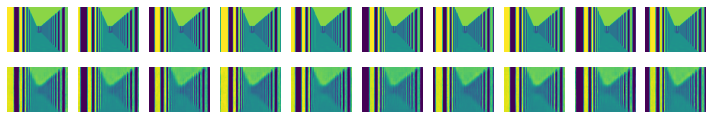

In [8]:
import random
import matplotlib.pyplot as plt

def plot_video_comparison(video, reconstructed_video):
    nb_frame = video.shape[0]
    fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    fig.tight_layout()

imgs = np.array(random.sample(list(data), 1))[0][20:30]
imgs_tensor = torch.tensor(imgs).to(device).float()
out_tensor, mu, logsigma = V_model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()

plot_video_comparison(imgs.squeeze(1),out.squeeze(1))

In [9]:
from models.mdrnn import MDRNN

M_model = MDRNN(
            latent_dim=parameters["latent_dim_mdrnn"],
            action_dim=parameters["action_dim_mdrnn"],
            hidden_dim=parameters["hidden_dim_mdrnn"],
            gaussians_nb=parameters["gaussians_nb_mdrnn"],
        ).to(device)

print("number of parameters :", count_parameters(M_model))

number of parameters : 8361


In [10]:
optimizer = torch.optim.Adam(
        M_model.parameters(), lr=parameters["learning_rate_mdrnn"]
    )

In [11]:
nb_epochs = parameters["nb_epochs_mdrnn"]
for epoch in range(nb_epochs):
    pbar = tqdm(joint_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch + 1))
    for obs,act in pbar:

        x = torch.reshape(obs, (-1, 1, 60, 80)).float().to(device)
        latents = V_model.encoder(x)[0]
        latents = torch.transpose(torch.reshape(latents, (-1, 100, 20)), 0, 1)
        
        seq_len, batch_size, _ = latents.shape

        if M_model.memory == "rnn":
            hidden = torch.zeros(batch_size, M_model.hidden_dim).to(device)
        else:
            hidden = (
                torch.zeros(batch_size, M_model.hidden_dim).to(device),
                torch.zeros(batch_size, M_model.hidden_dim).to(device),
            )
        actions = torch.transpose(act,0,1).to(device)
        optimizer.zero_grad()
        episode_loss = []
        
        for t in range(seq_len - 1):
            latent = latents[t, :, :]
            action = actions[t,:,:]
            latent_next_obs = latents[t + 1, :, :]

            if M_model.memory == "rnn":
                mus, sigmas, logpi, next_hidden = M_model(action, latent, hidden)
                hidden = next_hidden[1].squeeze(0)
            else:
                mus, sigmas, logpi, next_hidden = M_model(action, latent, hidden)
                hidden = next_hidden

            loss = M_model.loss_function(mus, sigmas, logpi, latent_next_obs)
            episode_loss.append(loss)

        episode_loss = torch.stack(episode_loss).sum()
        episode_loss.backward()
        optimizer.step()

        pbar.set_description(
            "epoch "
            + str(epoch + 1)
            + "/"
            + str(nb_epochs)
            + "  loss= "
            + str(loss.cpu().detach().numpy())
        )


epoch 1/100  loss= 24.031399:  31%|███▏      | 10/32 [00:02<00:05,  4.36it/s]


KeyboardInterrupt: 

In [96]:
# save model
# torch.save(M_model.state_dict(), "saved_models/mdrnn_z20.pt")

In [12]:
# load model
M_model.load_state_dict(torch.load("saved_models/mdrnn_z20.pt"))

<All keys matched successfully>

In [13]:

from plot_functions import plot_video_comparison,plot_SPE_metrics
from torch.distributions.normal import Normal

def gmm_loss(batch,mus,sigmas,logpi):

    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)

    return - log_prob


def run_model_prediction(video):

    loss = []
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,60,80)).float().to(device)
    reconstructed_video,latent_video, latent_video_variance  = V_model(video_tensor)
    latent_dim = latent_video.shape[-1]
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,latent_dim))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,latent_dim))
    reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,60,80))

    if M_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, M_model.hidden_dim).to(device)
    else :
        hidden = (torch.zeros(batch_size, M_model.hidden_dim).to(device),
                        torch.zeros(batch_size, M_model.hidden_dim).to(device))

    action = torch.zeros(batch_size, 3).to(device)

    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]

        if M_model.memory == 'rnn':
            mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
            hidden = next_hidden

        if t < seq_len-1 :
            loss.append( gmm_loss(latent_video[t+1,:,:],mus,sigmas,logpi).cpu().detach().numpy() )


        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    loss = np.stack(loss).T
    print(loss.shape)
    predicted_latent = torch.tensor(mean_pred).to(device)
    predicted_latent = torch.reshape(predicted_latent,(-1,20))
    predicted_video = V_model.decoder(predicted_latent)
    predicted_video = torch.reshape(predicted_video,(seq_len,batch_size,60,80))
    
    mean_pred = np.array(mean_pred).transpose(1,0,2)
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    predicted_video = predicted_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss

In [116]:
size = 200
random_index_1 = np.random.randint(1000,size=size)
random_index_2 = np.random.randint(1000,size=size)
video = data[random_index_1,:]

video = np.concatenate((data[random_index_1,0:10],data[random_index_1,10:0:-1]),axis=1) #  data[random_index_1,:90]  #  #
video = video.squeeze(2)
reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(video)
reconstructed_video.shape

(200, 19)


(200, 20, 60, 80)

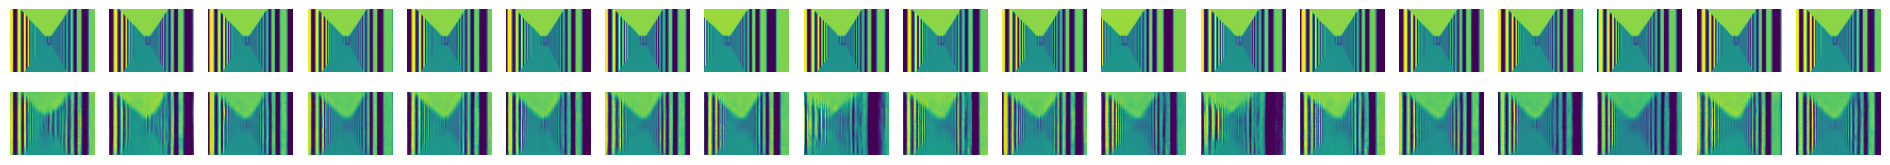

In [117]:
random_index_1 = np.random.randint(size,size=1)[0]
plot_video_comparison(video[random_index_1][1:],predicted_video[random_index_1][:-1])

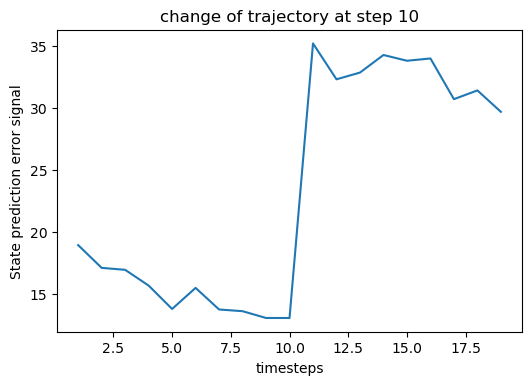

In [118]:
plt.figure()
plt.plot(list(range(1,20)),np.mean(loss,axis=0))
plt.xlabel('timesteps')
plt.ylabel('State prediction error signal')
plt.title('change of trajectory at step 10')
plt.show()

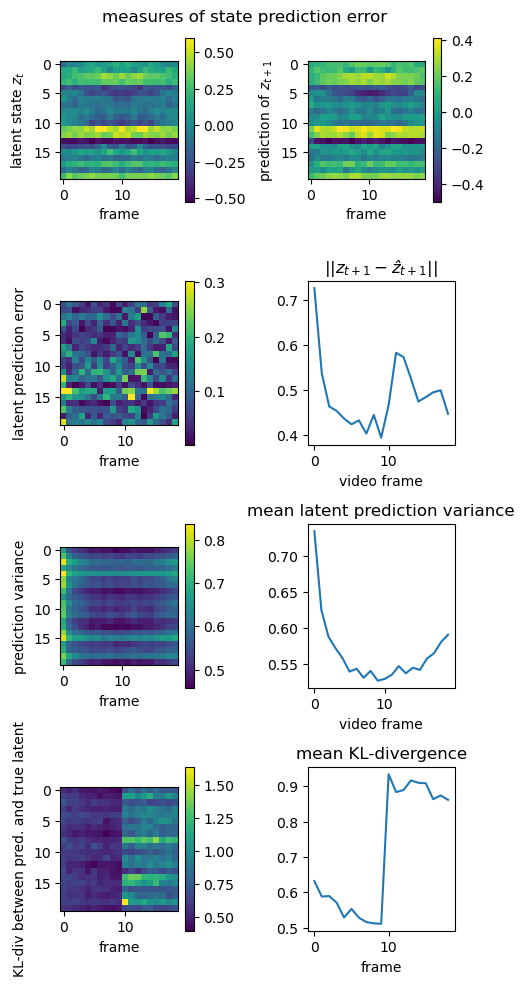

In [119]:
plot_SPE_metrics(latent_video, latent_video_variance, mean_pred, sig_pred)